In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

(None, None)

In [4]:
df.drop(columns=['id'], inplace=True)

In [5]:
train_num = df.select_dtypes(include=['number']).columns
train_cat = df.select_dtypes(exclude=['number']).columns

In [6]:
train_cat

Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object')

In [7]:
test_num = test_df.select_dtypes(include=['number']).columns
test_cat = test_df.select_dtypes(exclude=['number']).columns

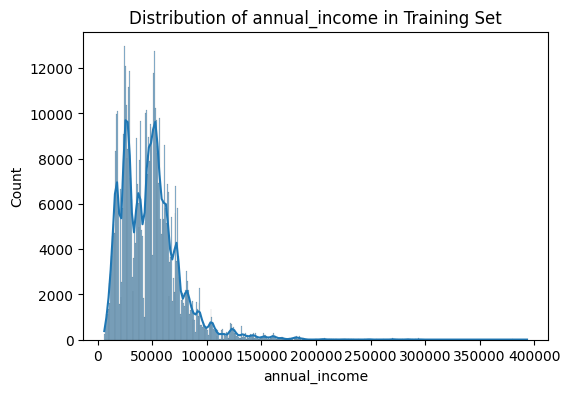

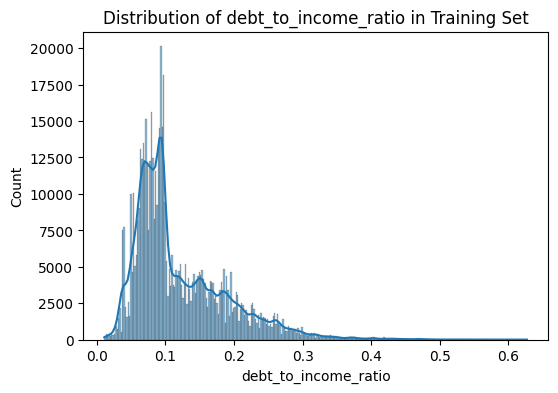

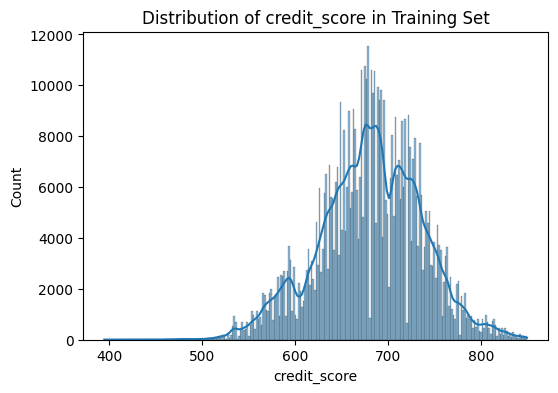

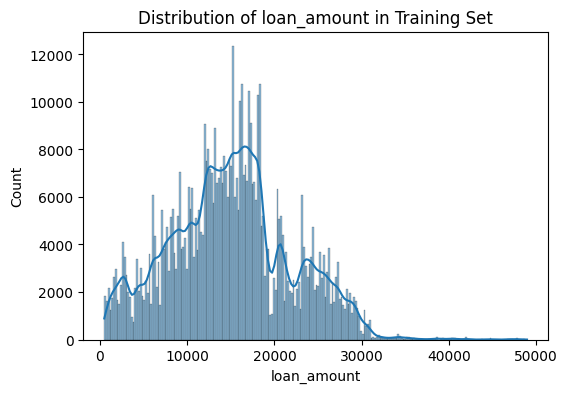

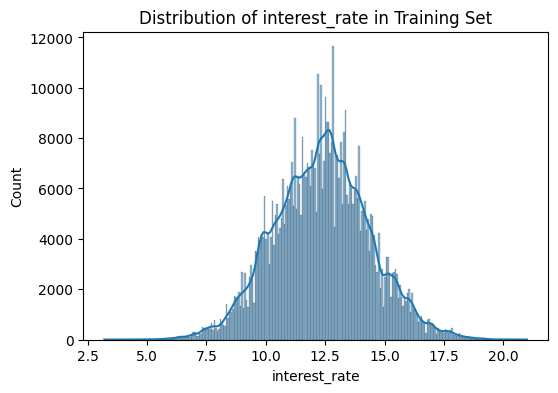

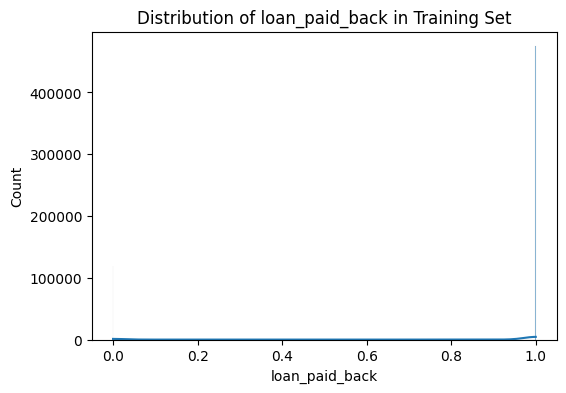

In [8]:
for col in train_num:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col} in Training Set')
    plt.show()

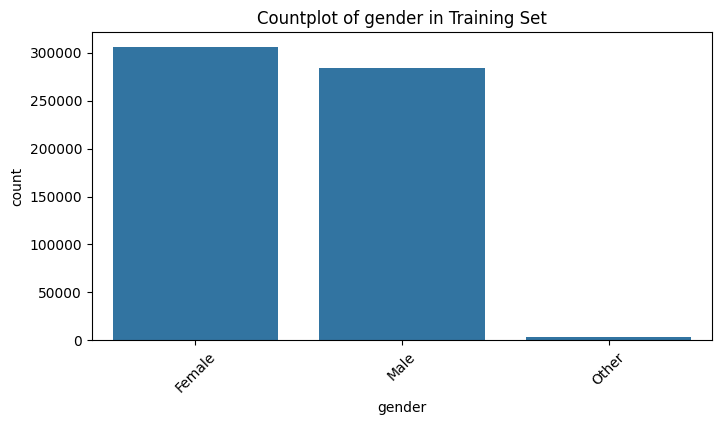

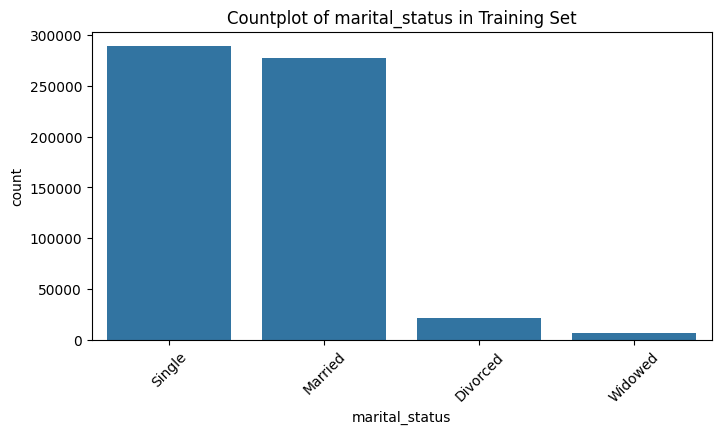

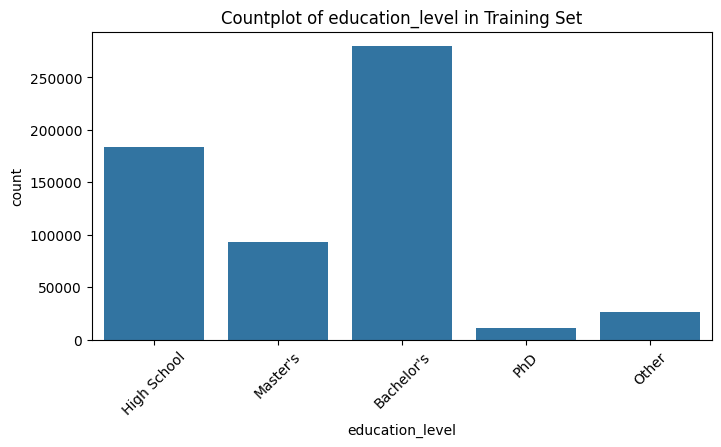

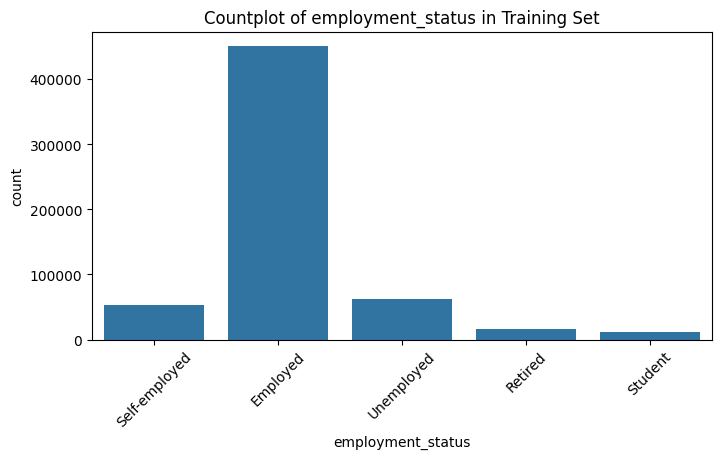

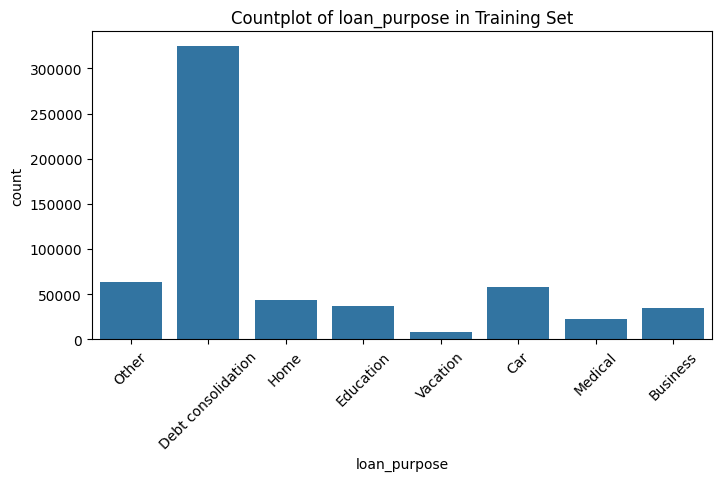

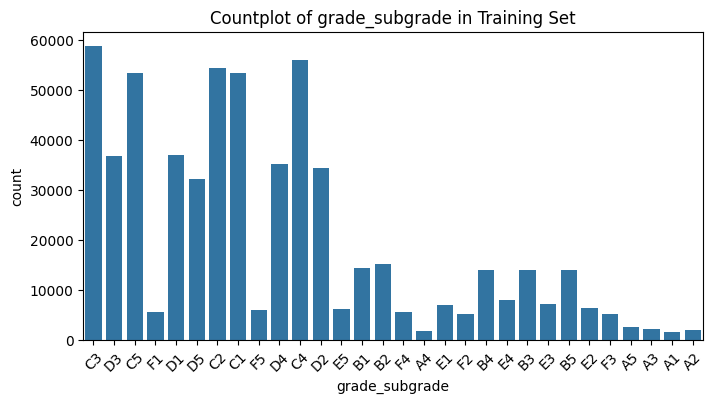

In [9]:
for col in train_cat:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col)
    plt.title(f'Countplot of {col} in Training Set')
    plt.xticks(rotation=45)
    plt.show()

In [10]:
df.describe()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


Text(0.5, 1.0, 'Loan Status Distribution')

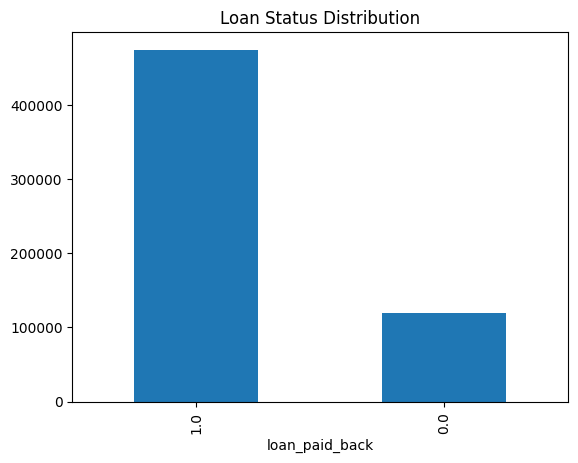

In [11]:
df['loan_paid_back'].value_counts().plot(kind='bar')
plt.title('Loan Status Distribution')

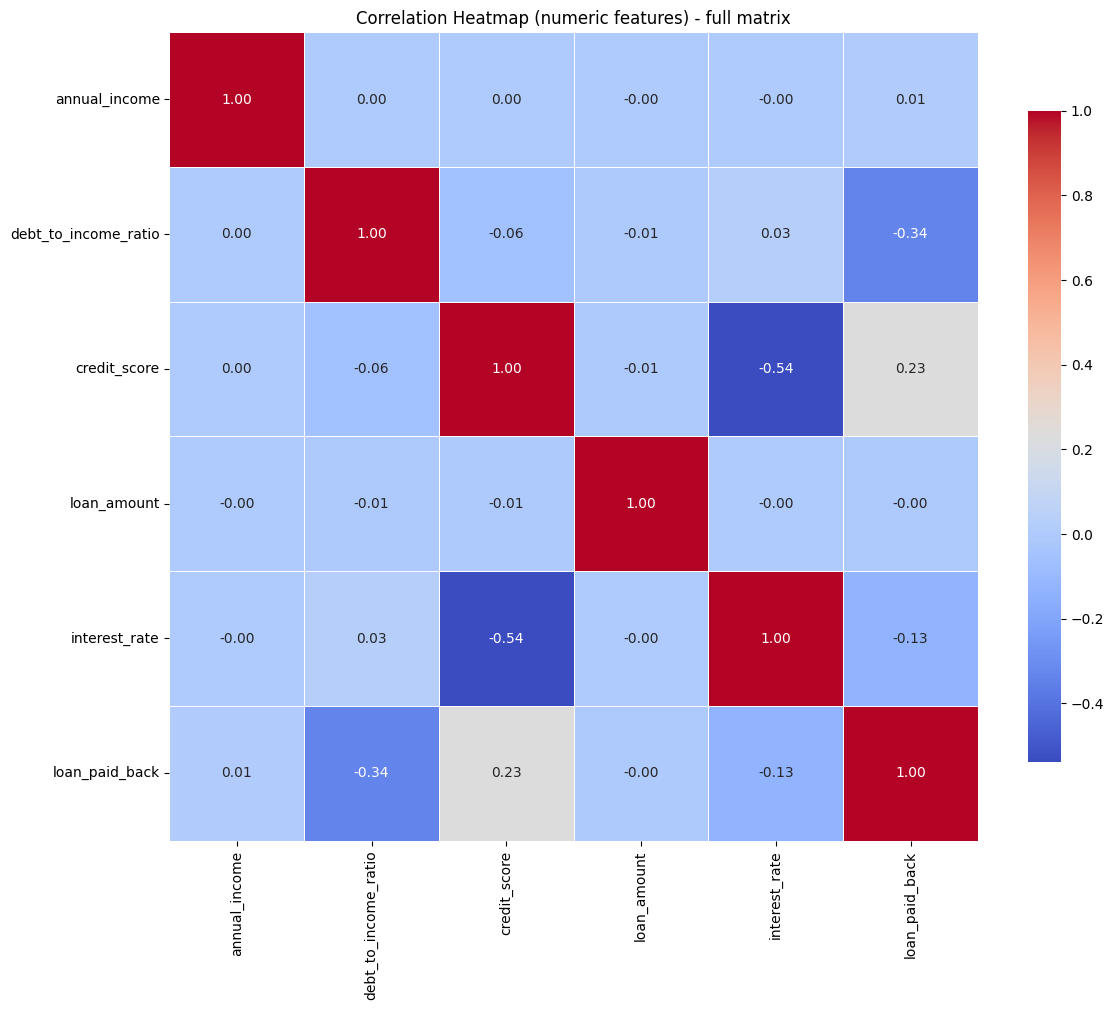

In [12]:
plt.figure(figsize=(12,10))
num_corr = df[train_num].corr()          # compute correlation of numeric columns
sns.heatmap(
    num_corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Heatmap (numeric features) - full matrix')
plt.tight_layout()
plt.show()

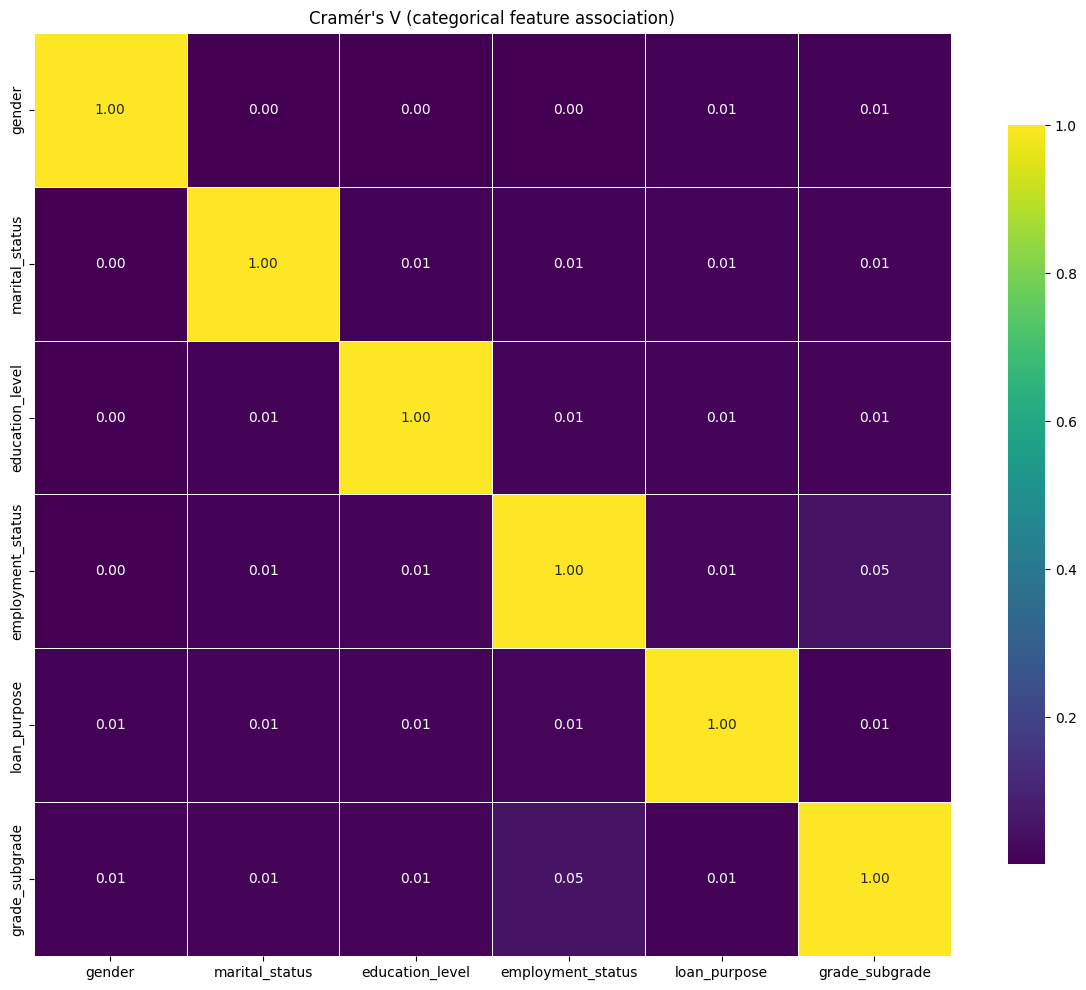

In [13]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    cm = pd.crosstab(x, y)
    if cm.size == 0:
        return 0.0
    chi2 = chi2_contingency(cm, correction=False)[0]
    n = cm.sum().sum()
    if n == 0:
        return 0.0
    phi2 = chi2 / n
    r, k = cm.shape
    # bias correction
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min(kcorr - 1, rcorr - 1)
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

cat_cols = list(train_cat)  

V = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))), index=cat_cols, columns=cat_cols)
for i, c1 in enumerate(cat_cols):
    for j, c2 in enumerate(cat_cols):
        if i <= j:
            val = cramers_v(df[c1].astype(str), df[c2].astype(str))
            V.at[c1, c2] = val
            V.at[c2, c1] = val

plt.figure(figsize=(12,10))
sns.heatmap(V, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5, cbar_kws={"shrink":0.8})
plt.title("Cramér's V (categorical feature association)")
plt.tight_layout()
plt.show()
# ...existing code...

# Obeservation 
##  1 there is no multicolinearity between the columns 
## 2 the numerical columns and categorical columns are skwed
## 3 the data is imbalanced
## 4 the data is high varience wiht some potential high bias in some feature 

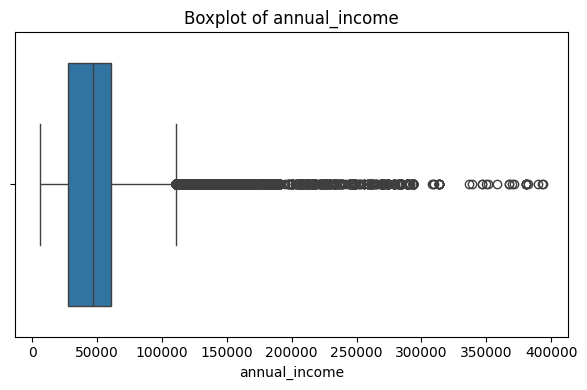

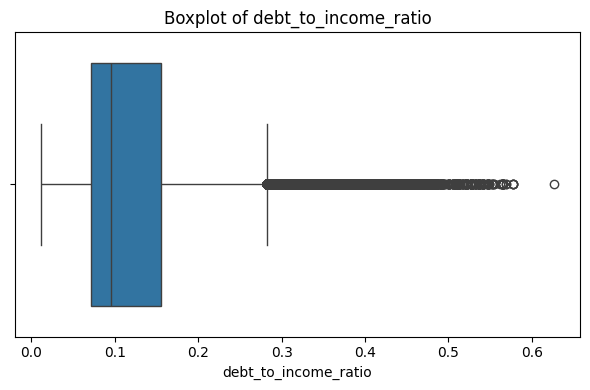

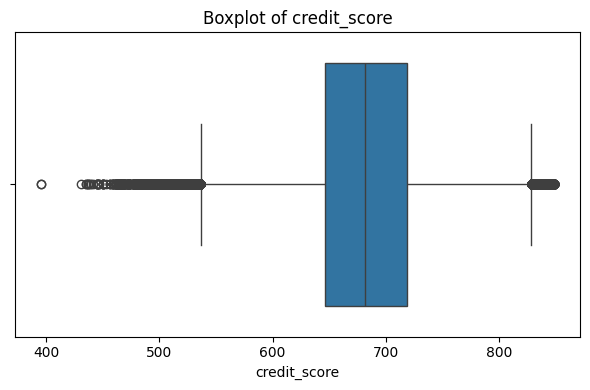

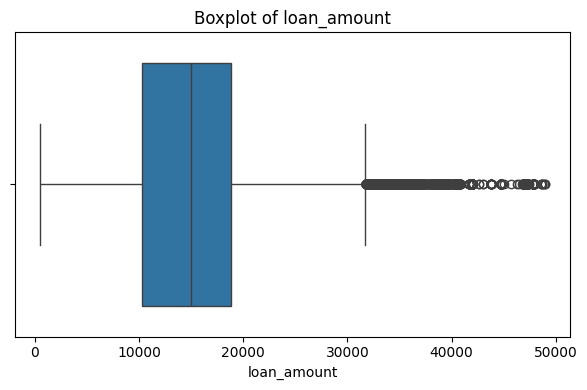

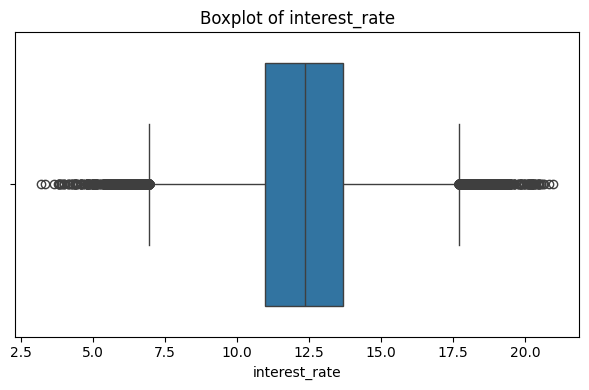

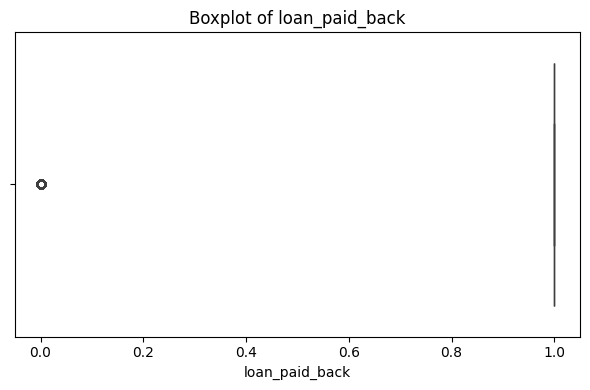

In [14]:

for col in train_num:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [15]:
df[col].value_counts(normalize=True) 

loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64

In [16]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01)
df['anomaly'] = iso.fit_predict(df[train_num])
print(len(df[df['anomaly'] == -1]))

5940


In [17]:
df_clean = df[df['anomaly'] != -1].copy()
df = df_clean.reset_index(drop=True)

# outlier removed using isolation forest

In [31]:
skewed_col = []
for col in df.select_dtypes(include=['number']).columns:
    skewness = df[col].skew()
    if abs(skewness) > 0.5:
        skewed_col.append(col)
    print(f'Skewness of {col}: {skewness}')

Skewness of credit_score: -0.14848247443102477
Skewness of loan_amount: 0.20229226616514429
Skewness of interest_rate: 0.02585693380835596
Skewness of loan_paid_back: -1.5366304618211182
Skewness of annual_income_transformed: -0.39137315703333697
Skewness of debt_to_income_ratio_transformed: 0.0004612463658147278


In [32]:
skewed_col

['loan_paid_back']

In [ ]:
from scipy.stats import boxcox
df['annual_income_transformed'] = np.log1p(df['annual_income'])
df['debt_to_income_ratio_transformed'], lmbda = boxcox(df['debt_to_income_ratio'])


In [22]:
test_df['annual_income_transformed'] = np.log1p(test_df['annual_income'])
test_df['debt_to_income_ratio_transformed'], lmbda = boxcox(test_df['debt_to_income_ratio'])

In [ ]:
df.drop(columns=['anomaly', 'annual_income', 'debt_to_income_ratio'], inplace=True)

In [ ]:

test_df.drop(columns=['annual_income', 'debt_to_income_ratio', 'id'], inplace=True)

In [24]:
df.head()

,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,annual_income_transformed,debt_to_income_ratio_transformed
0,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0,10.287695,-2.626917
1,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0,10.003741,-1.873748
2,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0,10.811085,-2.465798
3,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0,10.754904,-2.916758
4,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0,10.146344,-3.149956


In [28]:
test_df.head()

,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,annual_income_transformed,debt_to_income_ratio_transformed
0,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5,10.267507,-3.255590
1,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1,10.749943,-2.522175
2,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1,10.914286,-1.027978
3,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3,10.152128,-2.333884
4,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1,10.133434,-2.678314
